# Week7 - Decision Tree Lab & HW

## LAB

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).


## HW

* Train-test split
* Create 2 new pipelines for the following 2 models and use preprocessing pipeline you created in the previous step
    * a decison tree model https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    * a random forest model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Define params for GridSearchCV for both models
* Evaluate the models

* Explain findings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# DON'T CHANGE ANYTHING HERE....

random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )
    
    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000
    
    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]
    
    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6
    
    remove_values(df, df.columns, perc=0.05)
    
    return df, pd.Series(y)
    
X, y = create_df()

In [3]:
X.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


In [4]:
y.head()

0    1
1    0
2    0
3    0
4    1
dtype: int32

In [5]:
print(X)

              f1         f2           f3        f4        f5 f6
0       3.083178   3.022878  1276.390696 -2.672085  1.085629  B
1            NaN   1.764094  -873.709051  2.084035  0.387268  A
2       8.663599        NaN  -563.461158 -0.044922  2.512673  A
3            NaN   3.899908   753.129656  1.565944 -3.771516  A
4       0.684772  22.623978  -392.739840 -0.136113 -2.028027  A
...          ...        ...          ...       ...       ... ..
999995  0.166039   0.373037  -949.377892  1.474729  0.025967  B
999996  0.000004   4.528094   565.707592  0.675330 -1.407992  B
999997  0.586368   2.744505  -159.971366  1.249234 -0.400789  B
999998  2.354836   1.503345  2383.670899  0.822951  2.036277  B
999999  0.373415   0.142062  -859.153052  1.460491 -0.084982  A

[1000000 rows x 6 columns]


In [6]:
# eda code

In [7]:
X.describe()

,f1,f2,f3,f4,f5
count,9.499330e+05,9.498840e+05,949804.000000,950444.000000,950149.000000
mean,2.970269e+00,2.698242e+00,1.203865,-0.002337,-0.000394
std,4.223559e+00,3.863111e+00,1441.308642,1.682211,1.683646
min,7.464873e-15,4.200556e-12,-6319.721066,-8.364699,-7.067953
25%,3.265102e-01,3.144912e-01,-1077.181298,-1.172712,-1.186616
50%,1.415231e+00,1.310581e+00,-403.563631,0.067817,0.001923
75%,3.905995e+00,3.501739e+00,1009.950057,1.156616,1.152483
max,9.069379e+01,8.512300e+01,7402.596849,9.717087,8.354947


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f1      949933 non-null  float64
 1   f2      949884 non-null  float64
 2   f3      949804 non-null  float64
 3   f4      950444 non-null  float64
 4   f5      950149 non-null  float64
 5   f6      949983 non-null  object 
dtypes: float64(5), object(1)
memory usage: 45.8+ MB


<Axes: >

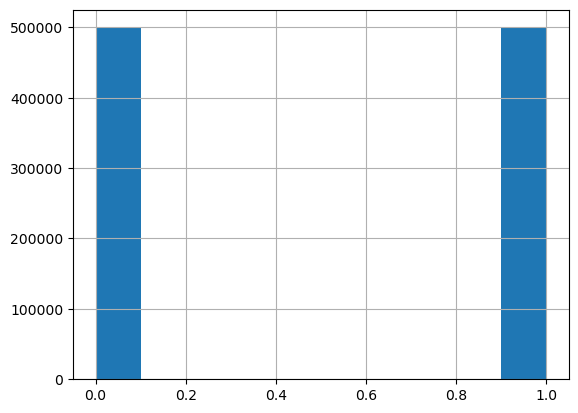

In [9]:
y.hist()

array([[<Axes: title={'center': 'f1'}>, <Axes: title={'center': 'f2'}>],
       [<Axes: title={'center': 'f3'}>, <Axes: title={'center': 'f4'}>],
       [<Axes: title={'center': 'f5'}>, <Axes: >]], dtype=object)

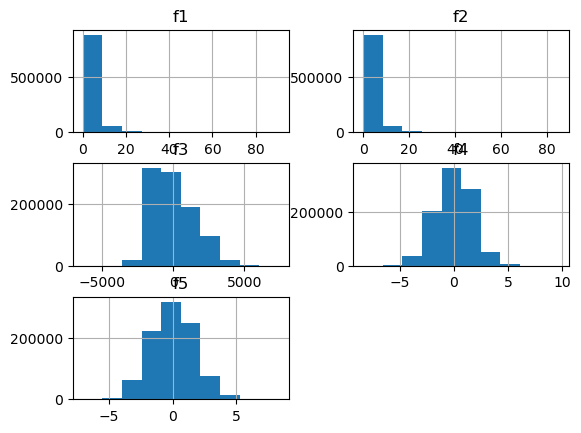

In [10]:
X.hist()

In [11]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

Explainations...

Here data was split into X and y,where X is having the features and y is target variable

X has features like f1,f2,f3,f4,f5

y is target variable with 0's and 1's

each feature has null values


ACCURACY would be the best metrics since target variable is balnced

Explain your gameplan...

1.Creating a pipeline for numerical and categorical variables and using imputers to  remove null values since we could see there are null values in the data

2.Since the data is verey big lets take subset of data to work on it

3.Split the data into training and testing 

4.Parameters should be defined for GridSearchCV

5.Models are trained using GridSearchCV and evalute both models

6.based on analysis we choose the best model based on accurcay


In [12]:
# create processing pipeline

In [13]:
numerical_features = ['f1', 'f2', 'f3', 'f4', 'f5']
categorical_features = ['f6']

In [14]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())  
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) 
])

In [15]:
processing_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),  
    ('cat', categorical_pipeline, categorical_features) 
])

In [16]:
modeling_pipeline = Pipeline([
    ('preprocessor', processing_pipeline), 
    ('classifier', RandomForestClassifier())  
])


## HW

In [17]:

from sklearn.model_selection import train_test_split
X_set = X[:10000]
y_set = y[:10000]

In [18]:


X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2, random_state=45)

In [19]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', DecisionTreeClassifier())])

In [20]:
dt_param_grid = [
  {
    'ml__max_depth': [ 5, 10, 15],
   'ml__min_samples_split':[2, 5, 10, 20],
   'ml__min_samples_leaf': [1,2, 5],
   'ml__class_weight':[None, 'balanced'] 
  }
]

scoring ='accuracy'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [21]:
dt_gcv_results.best_params_

{'ml__class_weight': None,
 'ml__max_depth': 10,
 'ml__min_samples_leaf': 2,
 'ml__min_samples_split': 20}

In [22]:
dt_gcv_results.score(X_train, y_train)

0.858

In [23]:
dt_gcv_results.score(X_test, y_test)

0.782

In [24]:
dt_gcv_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=20))])

Explain __shortly__ your findings how did you address the issues.

since the data set is too big(1million) we have taken subset with 10000 records

In [25]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier())])

In [26]:
rf_param_grid = [
    {
       'ml__max_depth': [ 5,10],           
        'ml__n_estimators': [ 10,50],   
        'ml__class_weight': [None, 'balanced'],   
        'ml__max_samples': [1000, 2000]
    }
]

scoring = 'accuracy'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [27]:
rf_gcv_results.best_params_

{'ml__class_weight': None,
 'ml__max_depth': 10,
 'ml__max_samples': 2000,
 'ml__n_estimators': 50}

In [28]:
rf_gcv_results.score(X_train, y_train)

0.849125

In [29]:
rf_gcv_results.score(X_test, y_test)

0.806

Explain __shortly__ your findings how did you address the issues.

since the data set is too big(1million) we have taken subset with 10000 records

Explain which model would you go with? 

here randomforest is giving more accuracy for both training and testing so i would prefer thatrather than decision tree

In [30]:
# create a new pipeline with the winner model and the best params
# evaluate the same results

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

rf_best_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_best_modeling_pipeline


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier())])

In [31]:
rf_best_param_grid = [
    {
        'ml__class_weight': ['balanced'],
        'ml__max_depth': [10],
        'ml__max_samples': [2000],
        'ml__n_estimators': [50]
    }

]

scoring = 'accuracy'

rf_best_gc = GridSearchCV(estimator=rf_best_modeling_pipeline, param_grid=rf_best_param_grid, cv=5, scoring=scoring)
rf_best_gcv_results = rf_best_gc.fit(X_train, y_train)

In [32]:
rf_best_gcv_results.score(X_train, y_train)

0.8179675

In [33]:
rf_best_gcv_results.score(X_test, y_test)

0.815785

Explain results

best parameters are taken from the winning model for GridSearchCV

whole dataset has 1 million instances

we got an accuracy of 81% for original dataset


